# Computes s/b and sample composition in a region
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- computes s/b and sample composition in a region defied by a cut
- make plots of s/b as function of cut thresholds
- implements an optimum finding algoritihm for the cut that maximizes s/b (at the end of the notebook)

In [16]:
import glob
import os
import json
import pickle
import yaml

import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils
plt.rcParams.update({"font.size": 20})

In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
! ls ../eos/Apr12_presel_2017

DYJetsToLL_M-10to50                     SingleElectron_Run2017E
DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to32

In [149]:
presel = {
    "mu": {
        
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        
        ### signal region
#         "tagger": " ( ( inclusive_score>0.9) )",
        
        ### top region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_L == 0) )",      

        ### qcd control region
#         "tagger": " ( ( inclusive_score<0.9) )",        
    },
    "ele": {
        
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",

        ### signal region
#         "tagger": " ( ( inclusive_score>0.9) )",
        
        ### top control region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_L == 0) )",     
        
        ### qcd control region
#         "tagger": " ( ( inclusive_score<0.9) )",
        
    }    
}

weights = {
    "ele": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_electron": 1,
        "weight_pileup": 1,
        "weight_reco_electron": 1,
        "weight_trigger_electron": 1,
        "weight_vjets_nominal": 1,
    },
    "mu": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_muon": 1,
        "weight_isolation_muon": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_vjets_nominal": 1   ,
    },       
}

In [152]:
years = ["2017"] #, "2016", "2016APV", "2018"]
channels = ["mu", "ele"]

samples_dir = f"../eos/Apr12_presel_"
# samples_dir = f"../eos/Jul12QCD_"
# samples_dir = f"../eos/Jul15_region_wjets_"

samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
#     "Data"
]

In [153]:
from make_hists import make_events_dict
events_dict = make_events_dict(years, channels, samples_dir, samples, presel, weights, "all", add_tagger_score=True)

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
1.0949416558557916
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 37101 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 4443 events
tot event weight 7156.94114046186 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Accumulating event weights.
0.010145824589325857
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
A

6.48577875218109
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 4 events
---> Done with preselection.
Will fill the WZQQ dataframe with the remaining 2 events
tot event weight 19.091754732214866 

Finding ST_tW_antitop_5f_inclusiveDecays samples and should combine them under SingleTop
---> Accumulating event weights.
0.007310314440539885
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with

Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
---> Accumulating event weights.
0.32004931028812356
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 537 events
---> Done with preselection.
Will fill the WZQQ dataframe with the remaining 360 events
tot event weight 169.45087139335365 

Finding ZZ samples and should combine them under Diboson
---> Accumulating event weights.
0.18607156555801924
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso

Finding ttHToNonbb_M125 samples and should combine them under ttH
---> Accumulating event weights.
0.0074459654816963535
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 17182 events
---> Done with preselection.
Will fill the ttH dataframe with the remaining 15629 events
tot event weight 52.85234523986145 

Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
---> Accumulating event weights.
0.05636894348394617
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
A

---> Accumulating event weights.
0.040375959087935856
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 267422 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 156248 events
tot event weight 8135.728116755879 

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Accumulating event weights.
0.0003367024440993835
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying presel

Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
---> Accumulating event weights.
0.0009944109678317447
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 32260 events
---> Done with preselection.
Will fill the SingleTop dataframe with the remaining 27196 events
tot event weight 83.75352389120548 

Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
---> Accumulating event weights.
0.00016254233968692665
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying

---> Applying preselection.
applying lep_fj_dr selection on 2113 events
---> Done with preselection.
Will fill the WZQQ dataframe with the remaining 1058 events
tot event weight 130.65751621657245 

Finding QCD_Pt_170to300 samples and should combine them under QCD
---> Accumulating event weights.
143.5180391829093
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 2661 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 921 events
tot event weight 116496.89407456071 

Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.08219963287816091
Applying weight_L1Prefiring weight
Applying weight

---> Accumulating event weights.
0.0002450397837281836
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 1204839 events
---> Done with preselection.
Will fill the DYJets dataframe with the remaining 276915 events
tot event weight 12283.532313203683 



In [143]:
events_dict.keys()

dict_keys(['2017'])

In [144]:
events_dict["2017"].keys()

dict_keys(['mu', 'ele'])

In [145]:
events_dict["2017"]["mu"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttH'])

# Compute s/b

In [146]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD"]

samples = events_dict["2017"]["mu"].keys()
samples

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttH'])

In [160]:
num_sig, num_bkg = {}, {}
num_bkg["Other"] = 0

deno_sig, deno_bkg = 0, 0
s, b = 0, 0

tagger_cut = 0.9

# event weights
for sample in samples:
    if sample=="Data":
        continue
        
    df_mu = events_dict["2017"]["mu"][sample]
    df_ele = events_dict["2017"]["ele"][sample]
    
    ### signal region
    # add tagger cut
#     df_mu = df_mu[df_mu["inclusive_score"]>tagger_cut]
#     df_ele = df_ele[df_ele["inclusive_score"]>tagger_cut]
    
    df_mu = df_mu[df_mu["inclusive_score2"]>0.99]
    df_ele = df_ele[df_ele["inclusive_score2"]>0.99]

#     df_mu = df_mu[df_mu["fj_pt"]/df_mu["lep_pt"]>1.6]
#     df_ele = df_ele[df_ele["fj_pt"]/df_ele["lep_pt"]>1.6]  
    
    
#     # dR cut
#     df_mu = df_mu[df_mu["lep_fj_dr"]<0.35]
#     df_ele = df_ele[df_ele["lep_fj_dr"]<0.35]
    
# # #     # nbjets cut
#     df_mu = df_mu[df_mu["n_bjets_T"]>=1]
#     df_ele = df_ele[df_ele["n_bjets_T"]>=1]
    
#     df_mu = df_mu[df_mu["n_bjets_L"]==0]
#     df_ele = df_ele[df_ele["n_bjets_L"]==0]
#     # VBF
#     df_mu = df_mu[df_mu["mjj"]>1000]
#     df_ele = df_ele[df_ele["mjj"]>1000]        
    
#     df_mu = df_mu[df_mu["deta"]>3.5]
#     df_ele = df_ele[df_ele["deta"]>3.5]        
    
#     df_mu = df_mu[np.abs(df_mu["met_fj_dphi"])<2]
#     df_ele = df_ele[np.abs(df_ele["met_fj_dphi"])<2]    

    ##############################    

    if sample in utils.signals:
        deno_sig += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
        num_sig[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
    else:
        deno_bkg += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()         
        if sample in dominant_backgrounds:
            num_bkg[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
        else:
            num_bkg["Other"] += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
        
num_sig["ggF"] = num_sig.pop("HWW")

num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))


print(f"Yuzhe's definition:")
print("Tagger>0.99")

print(rf"s/b: {deno_sig/(deno_bkg):.3f}")
print(rf"s/sqrt(b): {deno_sig/math.sqrt(deno_bkg):.2f}")
print("------------------------")
print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
#     print(f"- {sample}: {(num_sig[sample]/deno_sig):.3f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")  
#     print(f"- {sample}: {(num_bkg[sample]/deno_bkg):.3f}%")      

Yuzhe's definition:
Tagger>0.99
s/b: 0.010
s/sqrt(b): 0.93
------------------------
Signal: 88.02
- ttH: 8%
- VH: 16%
- VBF: 25%
- ggF: 51%
------------------------
Background: 8873.15
- QCD: 6%
- Other: 7%
- TTbar: 14%
- WJetsLNu: 74%


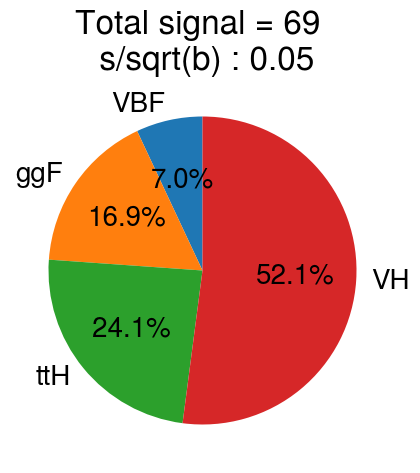

In [16]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(7, 5))
# Create the pie chart

patches, texts, autotexts = ax.pie(num_sig.values(), labels=num_sig.keys(), autopct='%1.1f%%', startangle=90)
for text in texts:
    text.set_size(20)
for autotext in autotexts:
    autotext.set_color('black')
    
# Add a title
plt.title(f"Total signal = {sum(list(num_sig.values())):.0f} \n s/sqrt(b) : {deno_sig/math.sqrt(deno_bkg):.2f}")

plt.show()

# Check s/b as a function of a cut

In [25]:
dr_cuts = np.linspace(0.1,0.8,21)

s_over_b = {}
for tagger_cut in [0, 0.9, 0.99]:
    s_over_b[tagger_cut] = []
    
    for dr_cut in dr_cuts:
        num_sig, num_bkg = {}, {}
        deno_sig, deno_bkg = 0, 0
        s, b = 0, 0
        for sample in ["HWW", "ttH", "VBF", "VH", "TTbar", "QCD", "WJetsLNu", "DYJets"]:

            df_mu = events_dict["2017"]["mu"][sample]
            df_ele = events_dict["2017"]["ele"][sample]

            ### signal region
            # add tagger cut
            df_mu = df_mu[df_mu["inclusive_score"]>tagger_cut]
            df_ele = df_ele[df_ele["inclusive_score"]>tagger_cut]

            # dR cut
            df_mu = df_mu[df_mu["lep_fj_dr"]<dr_cut]
            df_ele = df_ele[df_ele["lep_fj_dr"]<dr_cut] 
            
            # nbjets?
            df_mu = df_mu[df_mu["n_bjets_M"]<2]
            df_ele = df_ele[df_ele["n_bjets_M"]<2]            
            
            ##############################    
            if sample in utils.signals:
                num_sig[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
                deno_sig += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
            else:
                num_bkg[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
                deno_bkg += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()

        s_over_b[tagger_cut].append(deno_sig/math.sqrt(deno_bkg))

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

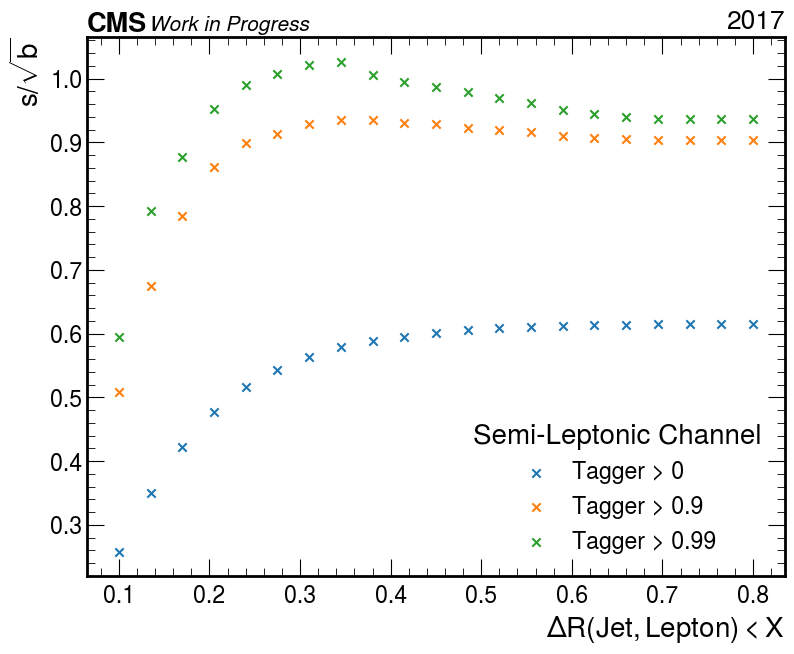

In [26]:
plt.rcParams.update({"font.size": 20})
### save plot
fig, ax = plt.subplots(figsize=(9, 7))
for tagger_cut in s_over_b:
    ax.scatter(dr_cuts, s_over_b[tagger_cut], marker="x", label=f"Tagger > {tagger_cut}")

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"$s/\sqrt{b}$"); 
ax.set_xlabel(r"$\Delta R(Jet,Lepton) < X$");
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

# Optimum finding algorithm

In [40]:
from tqdm.notebook import tqdm
def get_optimum_s_over_b(vars_, steps, apply_tagger=False):
    """
    Idea: given a range, fix the lower limit and do a "for loop" where you slide the upper limit to the left until 
    you hit the lower limit. Then increase the lower limit by one step and repeat.
    
    NOTE: for computational costs, and assuming the steps are always about a nice gaussian;
    the lower limit does not bypass the midpoint.
    """

    s, b = {}, {}
    
    midpoint = steps.mean()
    for low in tqdm(steps):
        if low>midpoint:
            break
        for high in tqdm(steps):
            if high<=low:
                continue
        
            s[f"{low:.2f}-{high:.2f}"], b[f"{low:.2f}-{high:.2f}"] = 0, 0
        
            for ch in channels:   # sum over channels
                for sample in events_dict["2017"][ch]:
                    df = events_dict["2017"][ch][sample]

                    ### apply tagger cut
                    if apply_tagger:
                        keep = ( df["inclusive_score"]>0.9 )
                        df = df.loc[keep, :]

                    # selection
                    if len(vars_)==2:
                        keep = ( df[vars_[0]]/df[vars_[1]]>low ) & ( df[vars_[0]]/df[vars_[1]]<high ) 
                    else:
                        keep = ( df[vars_[0]]>low ) & ( df[vars_[0]]<high )
    
                    df = df.loc[keep, :]            

                    ### mass window
                    mass_window = (df["fj_minus_lep_m"]>0) & (df["fj_minus_lep_m"]<150)

                    ### s/b
                    ev_weight = df["event_weight"]        
                    if sample in utils.signals:
                        s[f"{low:.2f}-{high:.2f}"] += ev_weight[mass_window].sum()
                    else:
                        b[f"{low:.2f}-{high:.2f}"] += ev_weight[mass_window].sum()   
         
    max_ = 0
    for range_ in s:
        s_over_b = s[range_]/np.sqrt(b[range_])
        if s_over_b >= max_:
            max_ = s_over_b
    
    for range_ in s:
        s_over_b = s[range_]/np.sqrt(b[range_])
        if s_over_b >= max_:
            print("range: s/b")    
            print(f"{range_} : {s[range_]/np.sqrt(b[range_]):.2f}")    
        
    return s, b

# dR(Jet,Lepton)

In [43]:
steps = np.linspace(0, 0.8, 11)
steps 

array([0.  , 0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 ])

In [44]:
s, b = get_optimum_s_over_b(["lep_fj_dr"], steps, apply_tagger=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

range: s/b
0.00-0.40 : 0.66


# pT(Jet)/pT(Lepton)

In [46]:
steps = np.linspace(0, 10, 11)
steps 

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [47]:
s, b = get_optimum_s_over_b(["fj_pt", "lep_pt"], steps, apply_tagger=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

range: s/b
0.00-10.00 : 0.65
range: s/b
1.00-10.00 : 0.65


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_62462/2161202164.py:52: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b = s[range_]/np.sqrt(b[range_])
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_62462/2161202164.py:57: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b = s[range_]/np.sqrt(b[range_])


# pT(W_lnu)/pT(W_qq)

In [48]:
steps = np.linspace(0, 10, 11)
steps

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [49]:
s, b = get_optimum_s_over_b(["rec_W_lnu_pt", "rec_W_qq_pt"], steps, apply_tagger=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

range: s/b
0.00-9.00 : 0.65
